In [1]:
!pip3 install ktrain

     |################################| 25.3 MB 24.1 MB/s eta 0:00:01
     |################################| 6.8 MB 7.8 MB/s eta 0:00:01
     |################################| 981 kB 30.5 MB/s eta 0:00:01
     |################################| 19.2 MB 28.7 MB/s eta 0:00:01
     |################################| 263 kB 35.1 MB/s eta 0:00:01
     |################################| 1.9 MB 32.0 MB/s eta 0:00:01
     |################################| 1.6 MB 38.2 MB/s eta 0:00:01
     |################################| 468 kB 37.5 MB/s eta 0:00:01
     |################################| 3.3 MB 39.0 MB/s eta 0:00:01
  Created wheel for ktrain: filename=ktrain-0.26.2-py3-none-any.whl size=25287859 sha256=b022291c50b9508979c8f730a12be4877cd5215d1c527ea568e08abca0973033
  Stored in directory: /root/.cache/pip/wheels/4d/80/6d/9b35559c05073aeed1f37a1e489782282679c8d67749c3c46a
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=994470 sha256=a75b87c85f3a77a25fb8475

In [1]:
import pandas as pd
import numpy as np
import ktrain
from ktrain import text

In [2]:
df = pd.read_csv('all_data.csv', names =['label', 'headline'], encoding='latin-1')

In [3]:
sentences = df.headline.values

In [4]:
labels = df.label.values

In [5]:
class_names = df.label.unique()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, 
                                                            random_state=56, test_size=0.2)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                            random_state=56, test_size=0.2)

In [8]:
import tensorflow as tf

MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=50, class_names=class_names)
trn = t.preprocess_train(X_train, y_train)
test = t.preprocess_test(X_test, y_test)
val = t.preprocess_test(X_val, y_val)

mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    model = t.get_classifier()

preprocessing train...
language: en
train sequence lengths:
	mean : 23
	95percentile : 42
	99percentile : 49


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 23
	95percentile : 42
	99percentile : 50


preprocessing test...
language: en
test sequence lengths:
	mean : 23
	95percentile : 43
	99percentile : 50


In [9]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)
learner.fit_onecycle(1e-5, 2)



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/2
194/194 [==============================] - 572s 3s/step - loss: 0.9166 - accuracy: 0.5684 - val_loss: 0.6865 - val_accuracy: 0.7049
Epoch 2/2
194/194 [==============================] - 606s 3s/step - loss: 0.4905 - accuracy: 0.8177 - val_loss: 0.4392 - val_accuracy: 0.8376


In [10]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

predictor.save('Bert_Retrained')

In [11]:
reloaded_predictor = ktrain.load_predictor('Bert_Retrained')

In [12]:
results = reloaded_predictor.predict(X_test)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

CR_test = classification_report(y_test, results)
print(CR_test)

cm = confusion_matrix(y_test, results)

              precision    recall  f1-score   support

    negative       0.73      0.78      0.75       116
     neutral       0.87      0.85      0.86       580
    positive       0.73      0.75      0.74       274

    accuracy                           0.81       970
   macro avg       0.78      0.79      0.78       970
weighted avg       0.81      0.81      0.81       970



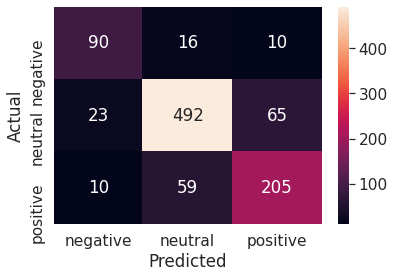

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
target_names = ['negative', 'neutral', 'positive']

df_cm = pd.DataFrame(cm, target_names, target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt='d') # font size

plt.show()